# Experimentos com o gerenciamento de grid

A ideia é calcular o fatiamento de uma imagem gigante, e depois localizar a posição exata em um dos quadrantes.

Com isso será possível fazer o processamento de uma imagem maior do que a memória ram disponível, dividindo ela em diversos quadrantes.

Posteriormente será estudado uma forma de unir todos os quadrantes na imagem final, mesmo que não tenha ram suficiente para montar da forma convencional.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [20]:
# simulando uma imagem gigante, mantendo um aspect ratio de 16:9
ratio = 16 / 9
# imgWidth = 137438953472 # teste de imagem maior do que a ram disponível
imgWidth = 1024 # teste básico paa cálculo
imgHeight = int(imgWidth / ratio)

imgHeight

576

In [54]:
# criado uma sequencia aleatória para gerar uma imagem de testes com as dimensões exatas para o teste
# o valor 3, refere aos canais de cores BGR (azul, verde, vermelho)
# https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html
img = np.random.random([imgHeight, imgWidth, 3]) * 255 # o mesmo que uint8
img = img.astype(int)
img[:] = img.mean(axis=-1,keepdims=1) # convertendo para escala de cinza
img

array([[[113, 113, 113],
        [141, 141, 141],
        [ 79,  79,  79],
        ...,
        [ 89,  89,  89],
        [117, 117, 117],
        [ 79,  79,  79]],

       [[ 87,  87,  87],
        [ 75,  75,  75],
        [102, 102, 102],
        ...,
        [156, 156, 156],
        [110, 110, 110],
        [158, 158, 158]],

       [[106, 106, 106],
        [ 75,  75,  75],
        [150, 150, 150],
        ...,
        [167, 167, 167],
        [130, 130, 130],
        [ 81,  81,  81]],

       ...,

       [[170, 170, 170],
        [155, 155, 155],
        [164, 164, 164],
        ...,
        [106, 106, 106],
        [135, 135, 135],
        [116, 116, 116]],

       [[ 74,  74,  74],
        [142, 142, 142],
        [134, 134, 134],
        ...,
        [116, 116, 116],
        [ 91,  91,  91],
        [ 71,  71,  71]],

       [[126, 126, 126],
        [ 96,  96,  96],
        [ 63,  63,  63],
        ...,
        [167, 167, 167],
        [104, 104, 104],
        [118, 118, 118]]

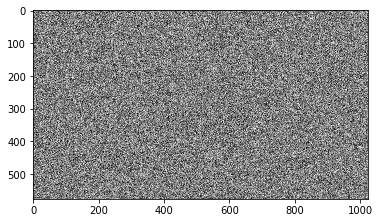

In [55]:
plt.imshow(img)